# Performance Counters

CFiddle provide easy access to hardware performance counters to count things like cache misses and branch mispredictions.

<div class="alert alert-block alert-warning">

In order for performance counters to work, you need access to your hardware's performance counters.   You can check the [perf_event_open man page](https://man7.org/linux/man-pages/man2/perf_event_open.2.html) for details about how to enable the `perf_events` interface on your system (It's usually turned on by default).

If you're in docker, you'll also need to start the container with `--privileged`.
    
</div>

Let's use to investigate the performance difference between `std::ordered_set` and `std::set` in the C++ STL.

## The Code

The code provides two functions that each fill a set with random integers.  We'll compile it with full optimizations.

In [2]:
from cfiddle import *
from cfiddle.perfcount import *
configure_for_jupyter()

In [3]:
exe = build(code(r"""
#include<set>
#include<unordered_set>
#include"cfiddle.hpp"

extern "C"
int build_set(int count) {
    std::set<uint64_t> s;
    uint64_t seed = 0xDEADBEEF;
    start_measurement();
    for(int i= 0; i < count; i++) {
        s.insert(fast_rand(&seed));
    }
    end_measurement();
    return s.size();
}

extern "C"
int build_unordered_set(int count) {
    std::unordered_set<uint64_t> s;
    uint64_t seed = 0xDEADBEEF;
    start_measurement();
    for(int i= 0; i < count; i++) {
        s.insert(fast_rand(&seed));
    }
    end_measurement();
    return s.size();
}

"""), arg_map(OPTIMIZE="-O3"))

  0%|          | 0/1 [00:00<?, ?it/s]

## Measuring Cache Misses and Instructions Executed

Here's the command to run the program and measure performance counters:

In [4]:
def exp_range(base, low, high):
    return [2**i for i in range(low,high)]

results = run(exe, 
              ["build_set", "build_unordered_set"], 
              arg_map(count=exp_range(2,8,24)), 
              perf_counters=["PERF_COUNT_HW_INSTRUCTIONS", "PERF_COUNT_HW_CACHE_L1D:READ:MISS"])

  0%|          | 0/32 [00:00<?, ?it/s]

Couldn't monitor event 'PERF_COUNT_HW_INSTRUCTIONS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_CACHE_L1D:READ:MISS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_INSTRUCTIONS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_CACHE_L1D:READ:MISS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_INSTRUCTIONS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_CACHE_L1D:READ:MISS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_INSTRUCTIONS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_CACHE_L1D:READ:MISS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_INSTRUCTIONS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_CACHE_L1D:READ:MISS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_INSTRUCTIONS': Operation not permitted
Couldn't monitor event 'PERF_COUNT_HW_CACHE_L1D:READ:MISS': Operation not permitted
Couldn't monitor event 'PERF_COUNT

The key is the `perf_counters` parameter which takes a list of performance counters to measure.  CFiddle supports all the hardware, software, and cache counters described in the [perf_event_open() man page](https://man7.org/linux/man-pages/man2/perf_event_open.2.html).  In this case, we'll count the number of level-1 data cach (`L1D`), read misses and the total number instructions executed.

We use Pandas data from opererations to compute some dervived metrics:

In [7]:
r = results.as_df()
r['L1_MissPerInsert'] = r["PERF_COUNT_HW_CACHE_L1D:READ:MISS"]/r["count"]
r['InstPerInsert'] = r["PERF_COUNT_HW_INSTRUCTIONS"]/r["count"]
r['L1_MPI'] = r["PERF_COUNT_HW_CACHE_L1D:READ:MISS"]/r["PERF_COUNT_HW_INSTRUCTIONS"]
display(r)

,OPTIMIZE,function,count,ET,PERF_COUNT_HW_INSTRUCTIONS,PERF_COUNT_HW_CACHE_L1D:READ:MISS,L1_MissPerInsert,InstPerInsert,L1_MPI
0,-O3,build_set,256,0.000246,0,0,0.0,0.0,NaN
1,-O3,build_set,512,0.003027,0,0,0.0,0.0,NaN
2,-O3,build_set,1024,0.000383,0,0,0.0,0.0,NaN
3,-O3,build_set,2048,0.000635,0,0,0.0,0.0,NaN
4,-O3,build_set,4096,0.001790,0,0,0.0,0.0,NaN
5,-O3,build_set,8192,0.002696,0,0,0.0,0.0,NaN
6,-O3,build_set,16384,0.004126,0,0,0.0,0.0,NaN
7,-O3,build_set,32768,0.009206,0,0,0.0,0.0,NaN
8,-O3,build_set,65536,0.021741,0,0,0.0,0.0,NaN
9,-O3,build_set,131072,0.070312,0,0,0.0,0.0,NaN


And then we can reshuffle that data to make comparisons and plotting easier:

In [8]:
import pandas as pd
pt = pd.pivot_table(r, index="count", values=["InstPerInsert", "L1_MissPerInsert", "ET"], columns="function")
display(pt)

ET                     InstPerInsert                      \
function  build_set build_unordered_set     build_set build_unordered_set   
count                                                                       
256        0.000246            0.000071           0.0                 0.0   
512        0.003027            0.000124           0.0                 0.0   
1024       0.000383            0.000285           0.0                 0.0   
2048       0.000635            0.000519           0.0                 0.0   
4096       0.001790            0.000873           0.0                 0.0   
8192       0.002696            0.001269           0.0                 0.0   
16384      0.004126            0.003156           0.0                 0.0   
32768      0.009206            0.004324           0.0                 0.0   
65536      0.021741            0.008426           0.0                 0.0   
131072     0.070312            0.022212           0.0                 0.0   
262144     0.186536            0.070785           0.0                 0.0   
524288     0.472087            0.179713           0.0                 0.0   
1048576    1.260310            0.462059           0.0                 0.0   
2097152    3.451240            1.098660           0.0                 0.0   
4194304    8.213530            2.702340           0.0                 0.0   
8388608   18.392300            5.843270           0.0                 0.0   

         L1_MissPerInsert                      
function        build_set build_unordered_set  
count                                          
256                   0.0                 0.0  
512                   0.0                 0.0  
1024                  0.0                 0.0  
2048                  0.0                 0.0  
4096                  0.0                 0.0  
8192                  0.0                 0.0  
16384                 0.0                 0.0  
32768                 0.0                 0.0  
65536                 0.0                 0.0  
131072                0.0                 0.0  
262144                0.0                 0.0  
524288                0.0                 0.0  
1048576               0.0                 0.0  
2097152               0.0                 0.0  
4194304               0.0                 0.0  
8388608               0.0                 0.0

## The Results

The results provide some insight into why `std::ordered_set` is roughly twice as fast at as `std::set` for inserts: While the number of instructions per access grows pretty slowly, the number _cache misses_ per accesses grows much faster for `std::set`  than `std::ordered_set`.

<AxesSubplot:xlabel='count', ylabel='ET'>

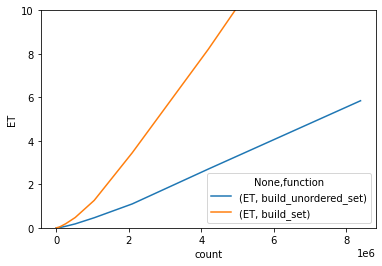

In [9]:
pt.plot.line(y=[("ET", "build_unordered_set"), ("ET", "build_set")], ylim=(0,10), ylabel="ET")

<AxesSubplot:xlabel='count', ylabel='Instruction Per Insert'>

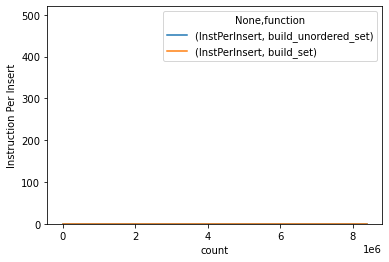

In [10]:
pt.plot.line(y=[("InstPerInsert", "build_unordered_set"), ("InstPerInsert", "build_set")], ylim=(0,520), ylabel="Instruction Per Insert")

<AxesSubplot:xlabel='count', ylabel='Misses per Insert'>

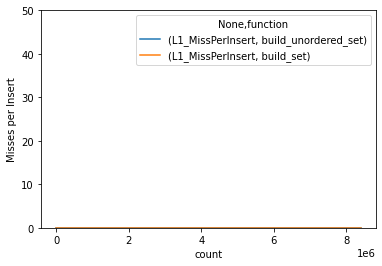

In [11]:
pt.plot.line(y=[("L1_MissPerInsert", "build_unordered_set"), ("L1_MissPerInsert", "build_set")], ylim=(0,50), ylabel="Misses per Insert")